# Implementation of Variational AutoEncoder (VAE)

     

In [1]:
#!pip install torch torchvision numpy tqdm]
#!pip install pyimagesearch
#!pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [3]:
import os
HOME_DIR = f"{os.environ['HOME']}/Documents/GitHub/Generative-AI"
dataset_path = f"{HOME_DIR}/datasets"

import sys
sys.path += [dataset_path]

from support import get_device

# Set device to GPU if available; otherwise CPU 
# Get current GPUs if available
device = get_device()

#Model hyperparameters
batch_size = 100
epochs = 200

# Dimensionality for encoder/decoder
x_dim  = 784 # input (encoder)/output (decoder) layer
hidden_dim = 400 #hidden layer
latent_dim = 200 #latent layer: encoder output, decoder input

# Learning rate
lr = 2e-4


###    Step 1. Load (or download) Dataset

In [4]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 0, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

100%|██████████████████████████████████████| 9.91M/9.91M [00:01<00:00, 7.30MB/s]
100%|███████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 289kB/s]
100%|██████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 2.66MB/s]
100%|██████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 1.41MB/s]


### Step 2a: Define base model - AutoEncoder
The AE_Model is a simple encoder/decoder pair.
<ul><li>AE_encoder: Translates the input (x) into lower dimensional latent space (z)</li>
<li>AE_decoder: Converts latent representation back into original image space (x-hat).</li>
<li>Loss function: similar to MSE between x and x-hat</li></ul>

In [5]:
class AE_Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        # nn.Linear(input features, output features, bias (True) - calculate additive bias)
        self.FC_input1 = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_latent = nn.Linear(hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True
    # forward - required for all NN models. It's what's run when the class is called like a function.
    def forward(self, x):
        h_ = self.LeakyReLU(self.FC_input1(x))
        h_ = self.LeakyReLU(self.FC_input2(h_))
        z  = self.LeakyReLU(self.FC_latent(h_))
        return z


class AE_Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        # nn.Linear(input features, output features, bias (True) - calculate additive bias)
        super().__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat


class AE_Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super().__init__()
        self.encoder = Encoder
        self.decoder = Decoder

    def forward(self, x):
        encoded = self.encoder(x)
        x_hat = self.decoder(encoded)
        return x_hat

In [6]:
ae_encoder = AE_Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
ae_decoder = AE_Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)
# instead of to(device), you may see .cuda() in other demos. That only works for Google Colab or NVIDIA GPUs.
ae_model = AE_Model(Encoder=ae_encoder, Decoder=ae_decoder).to(device) 

### Step 2b. Define our model: Variational AutoEncoder (VAE)
The VAE differs from the auto-encoder in these respects<ul>
<li>The encoder creates 2 vectors in latent space: the mean and log-variance of the underlying distribution (mu, sigma).</li>
<li>The reparameterization step converts the mean and log-variance values into a sample from a gaussian (z).</li>
<li>The decoder performs the same as before.</li>
<li>Loss function is both the reconstruction error <b>and</b> a measure of how well the latent space representation matches a standard normal distribution (KL divergence).</li></ul>

In [7]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""
# https://pytorch.org/docs/stable/generated/torch.nn.Module.html
# nn.Module is the base class for all NN modules
# Generate Encoder class as subclass of nn.Module
# The 'forward' method is what's executed when a torch.nn object is called like a function. It's a forward pass in the NN.
class VAE_Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        # nn.Linear(input features, output features, bias (True) - calculate additive bias
        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True

    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        return mean, log_var



In [8]:
# https://pytorch.org/docs/stable/generated/torch.nn.Module.html
# nn.Module is the base class for all NN modules
# Generate Decoder class as subclass of nn.Module
# The 'forward' method is what's executed when a torch.nn object is called like a function. It's a forward pass in the NN.
class VAE_Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat


In [9]:
# https://pytorch.org/docs/stable/generated/torch.nn.Module.html
# nn.Module is the base class for all NN modules
# Generate Model class as subclass of nn.Module
# The 'forward' method is what's executed when a torch.nn object is called like a function. It's a forward pass in the NN.

class VAE_Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super().__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)        # sampling epsilon
        z = mean + var*epsilon                          # reparameterization trick
        return z


    def forward(self, x):
        mean, log_var = self.Encoder(x) # x is raw input, my encoder takes x and gives mu and sigma which are functions of x.
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var


In [10]:
vae_encoder = VAE_Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
vae_decoder = VAE_Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

vae_model = VAE_Model(Encoder=vae_encoder, Decoder=vae_decoder).to(device)


### Step 3. Define Loss functions (reprod. loss) and optimizer

In [11]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def ae_loss_function(x, x_hat):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    return reproduction_loss

def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

ae_optimizer = Adam(ae_model.parameters(), lr=lr)
vae_optimizer = Adam(vae_model.parameters(), lr=lr)


### Step 4a. Train AutoEncoder (AE)

In [12]:
print("Start training AE...")
ae_model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        ae_optimizer.zero_grad()

        x_hat = ae_model(x)
        loss = ae_loss_function(x, x_hat)

        overall_loss += loss.item()

        loss.backward() # loss minimization
        ae_optimizer.step() # weight update

    if (epoch%10 == 0) or (epoch == epochs-1):
        print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

/opt/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Start training AE...
	Epoch 1 complete! 	Average Loss:  207.94971709033285
	Epoch 11 complete! 	Average Loss:  67.63015014444647
	Epoch 21 complete! 	Average Loss:  60.48575162706073
	Epoch 31 complete! 	Average Loss:  57.514906093489145
	Epoch 41 complete! 	Average Loss:  55.86267686541371
	Epoch 51 complete! 	Average Loss:  54.797370968215255
	Epoch 61 complete! 	Average Loss:  54.03126567553996
	Epoch 71 complete! 	Average Loss:  53.44688472486697
	Epoch 81 complete! 	Average Loss:  52.988135719363
	Epoch 91 complete! 	Average Loss:  52.61781482320795
	Epoch 101 complete! 	Average Loss:  52.30723093176127
	Epoch 111 complete! 	Average Loss:  52.035336049992175
	Epoch 121 complete! 	Average Loss:  51.801713386242696
	Epoch 131 complete! 	Average Loss:  51.59734272289754
	Epoch 141 complete! 	Average Loss:  51.410793355136164
	Epoch 151 complete! 	Average Loss:  51.24416252836759
	Epoch 161 complete! 	Average Loss:  51.086302797957536
	Epoch 171 complete! 	Average Loss:  50.9540685892

### Step 4b. Train Variational AutoEncoder (VAE)

In [13]:
print("Start training VAE...")
vae_model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        vae_optimizer.zero_grad()

        x_hat, mean, log_var = vae_model(x)
        loss = vae_loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward() # loss minimization
        vae_optimizer.step() # weight update

    if (epoch%10 == 0) or (epoch == epochs-1):
        print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")


Start training VAE...
	Epoch 1 complete! 	Average Loss:  213.18220445534223
	Epoch 11 complete! 	Average Loss:  113.2965146174614
	Epoch 21 complete! 	Average Loss:  106.04637387181761
	Epoch 31 complete! 	Average Loss:  102.64161189873748
	Epoch 41 complete! 	Average Loss:  100.94314448234036
	Epoch 51 complete! 	Average Loss:  99.74462623252296
	Epoch 61 complete! 	Average Loss:  98.87963379721411
	Epoch 71 complete! 	Average Loss:  98.26163392437917
	Epoch 81 complete! 	Average Loss:  97.76601595106428
	Epoch 91 complete! 	Average Loss:  97.3644403758869
	Epoch 101 complete! 	Average Loss:  97.03872342576169
	Epoch 111 complete! 	Average Loss:  96.75665935739254
	Epoch 121 complete! 	Average Loss:  96.48939818316987
	Epoch 131 complete! 	Average Loss:  96.23422132590777
	Epoch 141 complete! 	Average Loss:  96.07014226184265
	Epoch 151 complete! 	Average Loss:  95.84416470484662
	Epoch 161 complete! 	Average Loss:  95.67120588350376
	Epoch 171 complete! 	Average Loss:  95.54857685987

### Step 5. Compare AE vs VAE models
<ul>
<li>Image reconstruction</li>
<li>Continuity - a similar image should give a similar result</li>
<li>Completeness - any latent space input should give a meaningful result</li></ul>

In [14]:
import matplotlib.pyplot as plt

In [15]:
vae_model.eval()
ae_model.eval()
# torch.no_grad -- disable gradient computation.
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        x_hat_vae, _, _ = vae_model(x)
        x_hat_ae = ae_model(x)
        break

/opt/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|                                                   | 0/100 [00:00<?, ?it/s]


### 5a. Compare original image against those encoded/decoded by the AE, VAE

In [16]:
# Show list of images in nrows, ncols
def show_images(X, nrows=1, ncols=1, titles=[]):
    fig = plt.figure()
    for iter in range(len(X)):
        plt.subplot(nrows, ncols, iter+1).imshow(X[iter].cpu().numpy())
        try:
            plt.title(titles[iter])
            plt.axis('off')
        except:
            pass


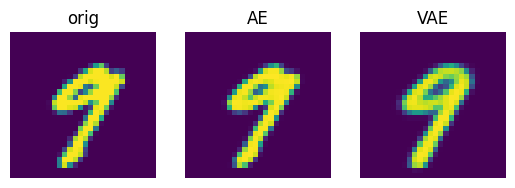

In [17]:
ix = 20
images = [img.view(batch_size,28,28)[ix].cpu() for img in [x, x_hat_ae, x_hat_vae]]
show_images(images, 1, 3, ["orig", "AE", "VAE"])

So the auto-encoder does a better job at what it's supposed to do -- maintain image quality during compression and decompression.

### 5b. Latent space continuity
Each image has values from 0-1. We will add random noise to the input image and see which encoder/decoder pair does a better job at returning an image most like the original.

In [18]:
with torch.no_grad():
    noise = (torch.randn(100,200) * 1.0).to(device)
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
        x_ae_encoded = torch.clamp((ae_model.encoder(x) + noise)/2, min=0, max=1)
        x_ae = ae_model.decoder(x_ae_encoded)
        vae_mean, vae_log_var = vae_model.Encoder(x) 
        x_vae_encoded = torch.clamp((vae_model.reparameterization(vae_mean, torch.exp(0.5 * vae_log_var)) + noise)/2, min=0, max=1)
        x_vae,_,_ = vae_model(vae_model.Decoder(x_vae_encoded))
        break

  0%|                                                   | 0/100 [00:00<?, ?it/s]


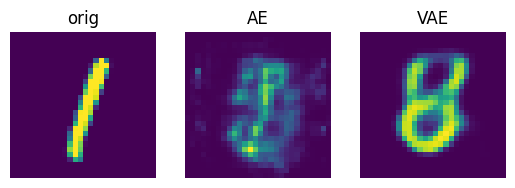

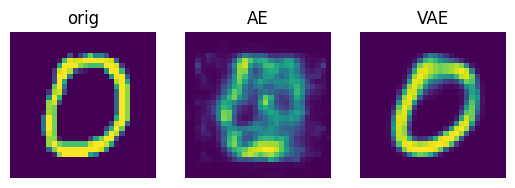

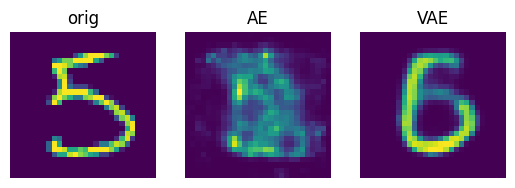

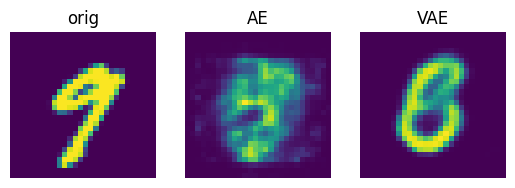

In [19]:
for i in [5,10,15,20]:
    noisey_images = [img.view(batch_size,28,28)[i].cpu() for img in [x, x_ae, x_vae]]
    show_images(noisey_images, 1, 3, ["orig", "AE", "VAE"])

Though neither encoder does particularly well, the VAE seems to keep the number shape better.

### 5c. Latent space completeness

**Please note that this is not the correct generative process.**

* Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.


In [20]:
with torch.no_grad():
    noise = torch.rand(batch_size, latent_dim).to(device)
    vae_generated_image = vae_decoder(noise)
    ae_generated_image = ae_decoder(noise)

In [21]:
#save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

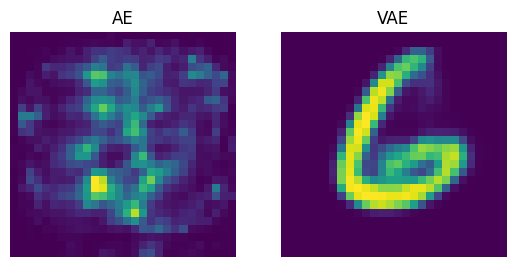

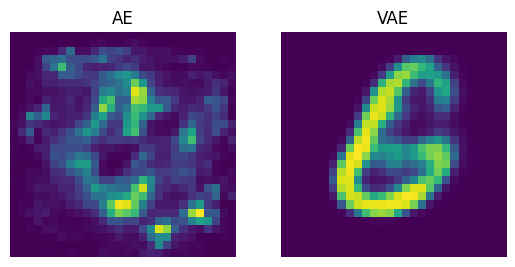

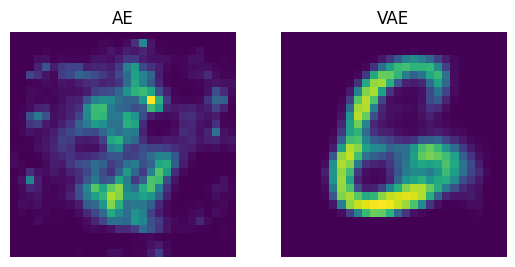

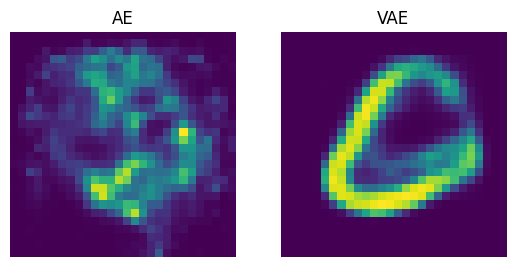

In [22]:
for i in [5,10,15,20]:
    images = [img.view(batch_size,28,28)[i].cpu() for img in [ae_generated_image, vae_generated_image]]
    show_images(images, 1, 2, [ "AE", "VAE"])


Aha! This is the value in VAEs; they learn the underlying shape of images even though there was no information on the input. This is why VAEs are so useful in generative AI.